# Photometry - Calculating Zero Points

Once you've measured how much light you received from a star, the next step is to figure out what that means in calibrated units - i.e., what you would have observed if there were no inefficiencies caused by the instrument or atmosphere.

This calibration process is critical for comparing observations!

For more details, have a look at [Stuart Littlefair's detailed description](http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/L04/index.html#stacks_out_1244_page13).

Learning goals are:
 
  * Practice looking up stars
  * Practice photometry measurement
  * Learn to use magnitude measurements to determine the magnitude zero-point for an observation
  

# Index

* [Repeat Basic Photometry, but faster](#Step-1:-Repeat-all-operations-from-"Basic-Photometry"-exercise)
* [Select stars](#Find-all-stars-we-want-to-measure)
* [Measure Photometry](#Measure-Photometry)
* [Finder Chart Matching](#Finder-chart-matching:-Look-up-the-stars)
* [Add coordinates to table](#Add-star-coordinates-to-our-table)
* [Look up stars: SIMBAD](#Look-up-stars:-SIMBAD)
* [Look up stars: Vizier](#Look-up-stars:-Vizier)
* [Build Calibration Table](#Build-Calibration-Table)
* [Magnitude Zero Point](#Magnitude-Zero-Point)
* [Sky Brightness](#Estimate-the-Sky-Background)
* [Exercise](#Exercise)
* [End](#End)

In [88]:
%matplotlib inline

In [89]:
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')

## Step 1: Repeat all operations from "Basic Photometry" exercise

[Index](#Index)

If you saved your dark- and sky-subtracted, flat-fielded image, you could just load that up here instead.

In [90]:
from astropy.io import fits
import os

In [91]:
# on my computer, the data are in a subdirectory called 'data/', so I chdir there
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\In CLass\\data_mar8_2021")

In [92]:
pleiades_clear_darksub_flattened = fits.getdata('pleiades_30s_C_other_001_darksub_flattened.fits')
pleiades_clear_darksub_flattened_uncertainty = fits.getdata('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits')

In [93]:
sky_mean = pleiades_clear_darksub_flattened.mean()
sky_median = np.median(pleiades_clear_darksub_flattened)
print(sky_mean, sky_median)

1035.2701922573067 1034.4351460591993


In [94]:
sky_stddev = pleiades_clear_darksub_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data: {sky_stddev:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {pleiades_clear_darksub_flattened_uncertainty.mean():0.1f}")

Standard deviation of the data: 53.1
Average of the per-pixel uncertainty from error propagation: 41.3


In [95]:
sky_subtracted_pleiades_clear = pleiades_clear_darksub_flattened - sky_mean

# Find all stars we want to measure
[Index](#Index)

The process is:

 * Show an image
 * Look at the image and identify some stars
 * Record the X,Y coordinates of the stars
 
This is probably easiest to do if you load up the image in ds9.

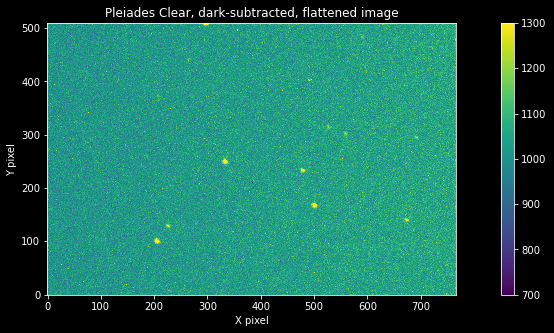

In [96]:
pl.figure(figsize=(16,5))
im = pl.imshow(pleiades_clear_darksub_flattened, origin='lower', interpolation='none', vmax=1300, vmin=700)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

In [97]:
star_centers = [[502,168], [335,250], [203,102], [228,130], [477,233], [673,140]]
width = 20
height = 20

To show where we found stars, we draw boxes around each of them.

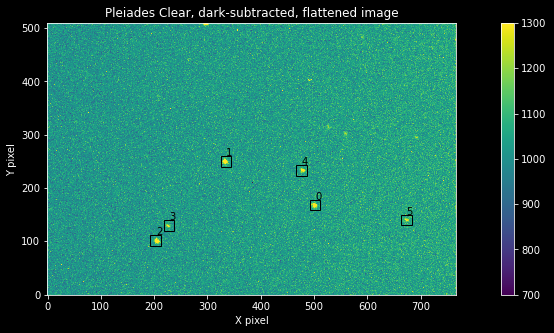

In [98]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(pleiades_clear_darksub_flattened, 
               origin='lower', interpolation='none', vmax=1300, vmin=700)
pl.colorbar(im)
_=pl.title("Pleiades Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

# Measure Photometry

[Index](#Index)

Using the tools we made at the end of the photometry notebook (`BasicPhotometry.ipynb`), we can measure the stars' counts.

In [99]:
def calculate_star_flux_and_error(cutout_star, cutout_uncertainty, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = ((cutout_uncertainty[mask]**2).sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

In [100]:
star_centers

[[502, 168], [335, 250], [203, 102], [228, 130], [477, 233], [673, 140]]

In [101]:
# the // means "divide by two, but return an integer (instead of a float)"
# single / means "divide by, then return a float"
502//2

251

In [102]:
# we are going to use cutouts around the star for their measurements
for (xc, yc) in star_centers:
    slc = slice(yc-height//2,yc+height//2),slice(xc-width//2,xc+width//2)
    print(slc)

(slice(158, 178, None), slice(492, 512, None))
(slice(240, 260, None), slice(325, 345, None))
(slice(92, 112, None), slice(193, 213, None))
(slice(120, 140, None), slice(218, 238, None))
(slice(223, 243, None), slice(467, 487, None))
(slice(130, 150, None), slice(663, 683, None))


There are two equivalent syntaxes to make a cutout:

```python
sky_subtracted_pleiades_clear[158:178, 492:512]
sky_subtracted_pleiades_clear[slice(158,178), slice(492,512)]
```

These do the same thing.  The former is "syntactic sugar" for the latter (that's a technical term that you don't need to know but might be useful if you're googling)

Then, we use a list comprehension (an inline for loop) to:

1. loop over the star centers
2. for each star, make a cutout around the star
3. for each star, make a cutout _of the uncertainty map_ around the star
4. Pass the cutouts, along with the sky background standard deviation to `calculate_star_flux_and_error`

In [103]:
results = [calculate_star_flux_and_error(
    sky_subtracted_pleiades_clear[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    pleiades_clear_darksub_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev)
           for (xc,yc) in star_centers]

It's a good idea to look at what we did.  We use another loop to show each of the cutout stars
along with a contour showing the mask we used.  We are reporting the sum over pixels contained within the mask:

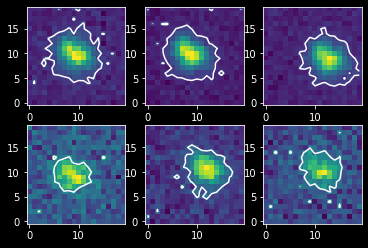

In [104]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_pleiades_clear[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev], colors=['w'])

We now add our results to a table to save them.

Astropy tables are useful tools for storing and displaying tabular data.

In [105]:
from astropy.table import Table

We extract the flux and uncertainty measurements from the `results` variable, which is a 2-dimensional array.

The `.T` here means "transpose".  The fluxes and uncertainties are presently in columns, e.g.:
```
[[1,2],
 [3,4],
 [5,6]]
``` 
 
But we want to put them into _rows_ so we can make a table out of them.  This is the transpose:
```
[[1,2,3],
 [4,5,6]]
```

In [106]:
fluxes, uncertainties = np.array(results).T

We then make a table with three columns: the star number, the fluxes, and the uncertainties

In [107]:
Table([np.arange(len(fluxes)), fluxes, uncertainties], names=['Star Number', 'Flux', 'Uncertainty'])

Star Number,Flux,Uncertainty
int32,float64,float64
0,35316.171723260944,700.1730852477532
1,40898.35182370345,696.7739320352291
2,39515.09479166292,668.7418749842823
3,8163.221738016462,435.20327093367445
4,18341.568210431426,582.6446125975509
5,10853.453148936138,533.3646210877812


# Finder chart matching: Look up the stars

[Index](#Index)

We now have measurements of 6 stars.  We need to calibrate them by looking up known photometric measurements in a catalog.  To do this, we have to figure out which stars they are!

This is probably best done using ds9 (demo recording [here](https://ufl.zoom.us/rec/play/Wny4jrohY1fctEe_LXqd2REM6NRtU8qr8RnaJztB7ymMd5Jj_gCYf1eAleMjAJsckNP9pvHLdNIOttxw.Ynu6Jk2VQtF1pzA_?continueMode=true&_x_zm_rtaid=h4gsRRw_QbugEy3jXCpJFw.1616984572261.b538290e278028974fddf4726ac67d54&_x_zm_rhtaid=28)), but I'll show how to do this in the notebook below.

In [108]:
from astroplan.plots import plot_finder_image
from astropy import units as u
from astropy.coordinates import SkyCoord

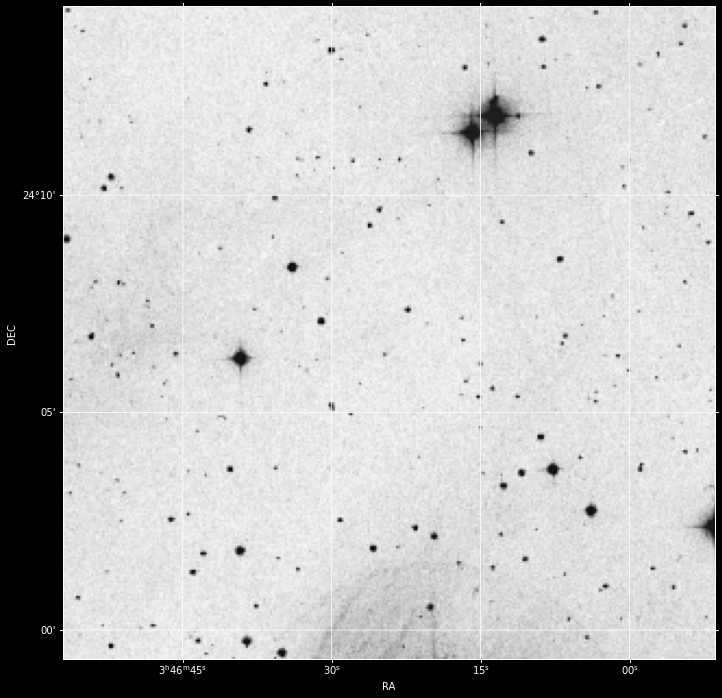

In [109]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('Pleiades'), survey='DSS', fov_radius=15*u.arcmin)

I found the stars by eye and matched them up to real coordinates using a finder chart loaded in ds9.

Record the stars' real coordinates:

In [110]:
star_coordinates = SkyCoord("""3:47:03.5093 +24:09:36.041
3:46:56.8012 +24:08:58.195
3:46:52.2998 +24:10:23.754
3:46:52.9937 +24:10:07.865
3:47:02.5002 +24:08:59.299
3:47:10.3589 +24:09:40.857""".split("\n"), frame='fk5', unit=(u.hour, u.deg))
star_coordinates

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(56.76462208, 24.16001139), (56.73667167, 24.14949861),
     (56.71791583, 24.173265  ), (56.72080708, 24.16885139),
     (56.7604175 , 24.14980528), (56.79316208, 24.16134917)]>

The astropy coordinates package can understand strings like we wrote them above.

We can also enter the coordinates in other ways:

In [111]:
SkyCoord("3:47:03.59", "24:09:36", unit=(u.hour, u.deg))

<SkyCoord (ICRS): (ra, dec) in deg
    (56.76495833, 24.16)>

We could even do the math ourselves:

In [112]:
SkyCoord(3+47/60+3.59/3600, "24:09:36", unit=(u.hour, u.deg)).to_string('hmsdms')

'03h47m03.59s +24d09m36s'

We can plot the stars' coordinates on top of the finder chart to prove we got them right:

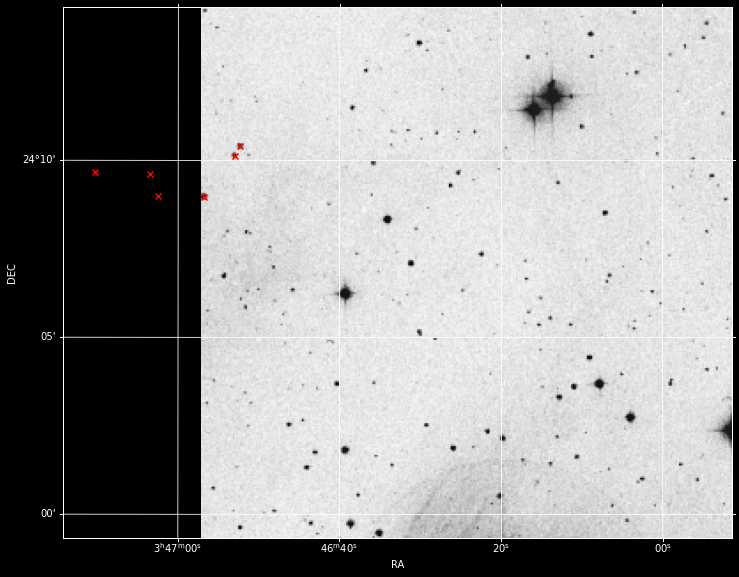

In [113]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('Pleiades'), survey='DSS', fov_radius=15*u.arcmin)
ax.scatter(star_coordinates.ra.deg, star_coordinates.dec.deg, transform=ax.get_transform('fk5'), marker='x', color='r')

# Add star coordinates to our table
[Index](#Index)

Now that we've identified the stars, we want to make a new table that includes the stars' true coordinates as one of the columns:

In [114]:
Table([np.arange(len(fluxes)), fluxes, uncertainties, star_coordinates.ra, star_coordinates.dec],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec'])

Star Number,Flux,Uncertainty,RA,Dec
,,,deg,deg
int32,float64,float64,float64,float64
0,35316.171723260944,700.1730852477532,56.76462208333332,24.160011388888886
1,40898.35182370345,696.7739320352291,56.73667166666666,24.14949861111111
2,39515.09479166292,668.7418749842823,56.71791583333332,24.173265
3,8163.221738016462,435.20327093367445,56.72080708333333,24.16885138888889
4,18341.568210431426,582.6446125975509,56.76041749999999,24.149805277777777
5,10853.453148936138,533.3646210877812,56.79316208333332,24.161349166666664


# Look up stars: SIMBAD
[Index](#Index)

Now we can look up the stars.

This process is similar to what we did in the Observation Planning notebooks.

In [115]:
from astroquery.simbad import Simbad

In [116]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('flux(B)', 'flux(V)', 'flux(I)')

In [117]:
simbad_rslt = Simbad.query_region(star_coordinates[0], radius=2*u.arcsec)
simbad_rslt

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,int32
V* V535 Tau,03 47 03.5821,+24 09 34.871,14,14,0.039,0.021,90,A,O,2018yCat.1345....0G,15.93,14.58,12.72,1


In [118]:
mags_star0 = simbad_rslt[['FLUX_B','FLUX_V','FLUX_I']]
mags_star0

FLUX_B,FLUX_V,FLUX_I
mag,mag,mag
float32,float32,float32
15.93,14.58,12.72


The second star doesn't have fluxes in the SIMBAD catalog:

In [119]:
Simbad.query_region(star_coordinates[1], radius=2*u.arcsec)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,int32
HAT 260-09130,03 46 56.8043,+24 08 58.151,14,14,0.130,0.086,90,A,O,2018yCat.1345....0G,--,--,--,1


# Look up stars: Vizier
[Index](#Index)

We can try a specific Vizier catalog:

In [120]:
from astroquery.vizier import Vizier

In [121]:
viz_result = Vizier.query_region(star_coordinates[1], radius=2*u.arcsec, catalog='I/322A/out')
viz_result

TableList with 1 tables:
	'0:I/322A/out' with 24 column(s) and 1 row(s) 

In [122]:
viz_result = Vizier.query_region('V1073 Ori', radius=15*u.arcsec, catalog='I/322A/out')
viz_result

TableList with 1 tables:
	'0:I/322A/out' with 24 column(s) and 1 row(s) 

In [123]:
viz_result[0]

UCAC4,RAJ2000,DEJ2000,ePos,f.mag,of,db,pmRA,pmDE,Jmag,Kmag,Bmag,Vmag,rmag,imag,H,A,b,h,Z,B,L,N,S
,deg,deg,mas,mag,,,mas / yr,mas / yr,mag,mag,mag,mag,mag,mag,,,,,,,,,
str10,float64,float64,int16,float32,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
423-010230,83.8684242,-5.4389753,55,9.921,1,0,-2.7,-2.8,9.386,9.315,9.711,9.712,9.799,9.757,0,1,0,0,1,1,0,0,0


In [124]:
mags_star1 = viz_result[0][['Bmag','Vmag','imag']]
mags_star1

Bmag,Vmag,imag
mag,mag,mag
float32,float32,float32
9.711,9.712,9.757


Rinse & repeat:

In [125]:
mags_for_stars = {}
for starnum in (0,1,2,3,4,5):
    viz_result = Vizier.query_region(star_coordinates[starnum], radius=2*u.arcsec, catalog='I/322A/out')
    mags_for_stars[starnum] = viz_result[0][['Bmag','Vmag','imag']]

In [126]:
mags_for_stars

{0: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  16.022  14.658  13.308,
 1: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  15.237  14.081  13.158,
 2: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.591  13.887  13.350,
 3: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
      --      --      --,
 4: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  15.093  14.623  14.338,
 5: <Table length=1>
   Bmag    Vmag    imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
      --      --      --}

Not all of the stars had good measurements.  We will ignore the stars that don't have measurements (that are masked) because we can't use them.

In [127]:
b_mags = [mags_for_stars[starnum]['Bmag'][0] for starnum in (0,1,2,3,4,5,)]
b_mags

[16.022, 15.237, 14.591, masked, 15.093, masked]

In [128]:
v_mags = [mags_for_stars[starnum]['Vmag'][0] for starnum in (0,1,2,3,4,5,)]
v_mags

[14.658, 14.081, 13.887, masked, 14.623, masked]

In [129]:
i_mags = [mags_for_stars[starnum]['imag'][0] for starnum in (0,1,2,3,4,5,)]
i_mags

[13.308, 13.158, 13.35, masked, 14.338, masked]

# Build Calibration Table

[Index](#Index)

In [130]:
cal_table = Table([np.arange(len(fluxes)), fluxes*u.electron, uncertainties*u.electron, star_coordinates.ra, star_coordinates.dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table

Star Number,Flux,Uncertainty,RA,Dec,Vmag,Bmag,Imag
,electron,electron,deg,deg,,,
int32,float64,float64,float64,float64,float64,float64,float64
0,35316.171723260944,700.1730852477532,56.76462208333332,24.160011388888886,14.657999992370605,16.02199935913086,13.307999610900879
1,40898.35182370345,696.7739320352291,56.73667166666666,24.14949861111111,14.081000328063965,15.237000465393066,13.157999992370605
2,39515.09479166292,668.7418749842823,56.71791583333332,24.173265,13.88700008392334,14.590999603271484,13.350000381469727
3,8163.221738016462,435.20327093367445,56.72080708333333,24.16885138888889,--,--,--
4,18341.568210431426,582.6446125975509,56.76041749999999,24.149805277777777,14.623000144958496,15.093000411987305,14.338000297546387
5,10853.453148936138,533.3646210877812,56.79316208333332,24.161349166666664,--,--,--


From http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.V&&mode=browse&gname=Generic&gname2=Bessell#filter, we get the Bessel-V zero-magnitude flux 3579.76 Jy.

In [131]:
bessel_v_mag0 = 3579.76*u.Jy

For star 0, then, we have:

In [132]:
mag_v_0 = cal_table['Vmag'][0]
flux_v_0 = 10**(-mag_v_0/2.5) * bessel_v_mag0
mag_v_0,flux_v_0

(14.657999992370605, <Quantity 0.00490517 Jy>)

The same star produces a count rate calculated by dividing the total counts by the exposure time:

In [133]:
exptime = fits.getheader('pleiades_30s_C_other_001_darksub_flattened.fits')['EXPTIME'] * u.s
exptime

<Quantity 30. s>

In [134]:
star_0_electron_counts = cal_table['Flux'].quantity[0]
star_0_countrate = star_0_electron_counts / exptime
star_0_countrate

<Quantity 1177.20572411 electron / s>

So we end up with star 0 has flux 0.005 Jy (5 mJy) and produces 1200 counts/second.

# Magnitude Zero Point

[Index](#Index)

To get the zeropoint, we want the magnitude that produces 1 electron (1 count) per second:


We  define this by setting the zero point based on the flux received in one second:

$$m_{inst} \equiv m_{*, observed~in~1s} \equiv - 2.5 \log \frac{counts}{t_{exp}} $$

We can then derive the zero-point by relating our _instrumental magnitude_ ($m_{inst}= m_{*, observed~in~1s}$) to the catalogued, "known" magnitude

$$ m_{*, catalog} = m_{*, observed~in~1s} + m_{zp}$$

We then solve for the zero-point magnitude $m_{zp}$

In [135]:
# first we calculate the instrumental magnitude in two different, equivalent ways:
-2.5*np.log10(star_0_countrate.value), -2.5*np.log10(star_0_electron_counts.value) + 2.5*np.log10(exptime.value)

(-7.6771309129241345, -7.6771309129241345)

In [136]:
# solve for the zero point
star_0_instrumental_mag = -2.5*np.log10(star_0_countrate.value)
zeropoint = mag_v_0 - star_0_instrumental_mag 
star_0_instrumental_mag, zeropoint

(-7.6771309129241345, 22.33513090529474)

We repeat for the other stars:

In [137]:
zeropoint_measurements = []
for row in cal_table:
    mag_v = row['Vmag']
    if mag_v:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_v - star_instrumental_mag 
        print(f"Instrumental magnitude of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements.append(zeropoint)

Instrumental magnitude of star 0=-7.7, m_zp=22.3
Instrumental magnitude of star 1=-7.8, m_zp=21.9
Instrumental magnitude of star 2=-7.8, m_zp=21.7
Instrumental magnitude of star 4=-7.0, m_zp=21.6


The zero-point should be the same for all stars.  It isn't in this case, but it's pretty close for the first two stars.  

There are several reasons some stars could give incorrect zero-points:
 * Some sort of problem with the flux measurement for that star (hot pixel, cosmic ray, etc)
 * The star may be variable
 * We could have mis-matched the star to the catalog
 * There could be differences between the star and the catalog

### Zero-point uncertainty

Because we have multiple measurements, we can use the standard deviation of the measurements as a quantitative estimate of our uncertainty.

In [138]:
avg_zp, std_zp = np.mean(zeropoint_measurements),np.std(zeropoint_measurements)
print(f"Zero-point is estimated to be {avg_zp:0.1f}+/-{std_zp:0.1f}")

Zero-point is estimated to be 21.9+/-0.3


# Estimate the Sky Background

[Index](#Index)

We already determined the average sky background in electrons:

In [139]:
sky_mean

1035.2701922573067

The magnitude, per pixel, is then:

In [140]:
mag_sky_inst = -2.5 * np.log10(sky_mean / exptime.value)
mag_sky_inst

-3.8448311379067563

In [141]:
mag_sky = mag_sky_inst + avg_zp
print(f"Sky magnitude is {mag_sky:0.1f} per pixel")

Sky magnitude is 18.0 per pixel


If we know our pixel scale, which we can measure from comparing star locations in the finder chart to those in the image, we can get the surface brightness in magnitudes per square arcsecond.


$$m_{per~arcsec} - m_{per~pix} = -2.5 \log \frac{1 arcsec^2}{pixel~area}$$

In [142]:
pixscale = 0.55*u.arcsec # 1-dimensional pixel scale

In [143]:
sky_brightness = mag_sky + 2.5*np.log10(pixscale**2 / u.arcsec**2)
print(f"The sky surface brightness is {sky_brightness:0.1f} magnitudes per square arcsecond")

The sky surface brightness is 16.7 magnitudes per square arcsecond


# Exercise

Do these calculations for your data on the star cluster:

* [Select stars](#Find-all-stars-we-want-to-measure)
* [Measure Photometry](#Measure-Photometry)
* [Finder Chart Matching](#Finder-chart-matching:-Look-up-the-stars)
* [Add coordinates to table](#Add-star-coordinates-to-our-table)
* [Look up stars: SIMBAD](#Look-up-stars:-SIMBAD)
* [Look up stars: Vizier](#Look-up-stars:-Vizier)
* [Build Calibration Table](#Build-Calibration-Table)
* [Magnitude Zero Point](#Magnitude-Zero-Point)
* [Sky Brightness](#Estimate-the-Sky-Background)


# End

[Index](#Index)

In [144]:
import os

In [145]:
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

In [146]:
import glob 

biases = glob.glob("Darks\\dark_40ms*.FIT")
dark_40ms = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in biases]
average_40ms_dark = np.mean(dark_40ms, axis=0)
stddev_40ms_dark = np.std(dark_40ms, axis=0)
del dark_40ms

In [147]:
bias_timestream = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in biases]
mean_bias = np.mean(bias_timestream, axis=0)
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.mean(stddev_bias)
del bias_timestream

In [148]:
dark20s = glob.glob("Darks\\dark_20s*.FIT")
dark_20s = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in dark20s]
average_20s_dark = np.mean(dark_20s, axis=0)
stddev_20s_dark = np.std(dark_20s, axis=0)
del dark_20s

In [149]:
clear_flat = glob.glob("Twighlight Flats\\flat_15s_Clear*FIT")
I_flat = glob.glob("Twighlight Flats\\flat_10s_I*FIT")
B_flat = glob.glob("Twighlight Flats\\flat_15s_B*FIT")
V_flat = glob.glob("Twighlight Flats\\flat_15s_V*FIT")

In [150]:
#Clear, B , V , I
flat = [clear_flat,B_flat,V_flat,I_flat]
flat_timestream = []
mean_flat = []
bias_subtracted_flat = []
normed_flat = []

for i in range(1):
    flat_timestream.append([fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in flat[i]])
    mean_flat.append(np.mean(flat_timestream[i], axis=0))
    bias_subtracted_flat.append(mean_flat[i] - mean_bias)
    normed_flat.append(bias_subtracted_flat[i]/bias_subtracted_flat[i].mean())
    
del flat_timestream

In [151]:
mean_bias_noise = readnoise / np.sqrt(len(biases))
mean_bias_noise

6.321659545083941

In [152]:
gain = fits.getheader("Twighlight Flats\\flat_15s_Clear001.FIT")['EGAIN']
flat_poisson_uncertainty = []
flat_singleframe_uncertainty = []
flat_total_uncertainty = []
normalized_mean_flat = []

for i in range(4):
    flat_poisson_uncertainty.append((bias_subtracted_flat[i])**0.5)
    flat_singleframe_uncertainty.append((flat_poisson_uncertainty[i]**2 + readnoise**2)**0.5)
    flat_total_uncertainty.append(((flat_singleframe_uncertainty[i]/np.sqrt(len(flat[i])))**2 + mean_bias_noise**2)**0.5)
    mean_of_flat = np.mean(bias_subtracted_flat[i])
    normalized_mean_flat.append(bias_subtracted_flat[i] / mean_of_flat)

IndexError: list index out of range

In [153]:
uncertainty_on_20s_mean_dark = stddev_20s_dark / np.sqrt(len(dark20s))

In [154]:
M13_shift = fits.getdata('M13\\M13_20s_Clear001.FIT')*fits.getheader('M13\\M13_20s_Clear001.FIT')[ 'EGAIN']

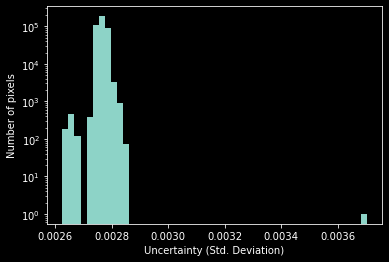

In [155]:
normalized_flat_uncertainty = []
for i in range(1):
    pl.figure()
    normalized_flat_uncertainty.append(flat_total_uncertainty[i] / mean_of_flat)
    pl.xlabel("Uncertainty (Std. Deviation)")
    pl.ylabel("Number of pixels")
    _=pl.hist(normalized_flat_uncertainty[i].ravel(), bins=50, log=True)

In [156]:
M13_darksub = (M13_shift - average_40ms_dark)
M13_darksub_uncertainty = ((M13_darksub + readnoise**2 + uncertainty_on_20s_mean_dark**2)**0.5)
M13_darksub_flattened = ( M13_darksub / normalized_mean_flat[0])
M13_darksub_flattened_uncertainty = (((M13_darksub_uncertainty**2 / M13_darksub**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[0]**2) * M13_darksub_flattened**2)**0.5) 

In [157]:
M13_darksub_flattened.shape

(510, 765)

In [160]:
header = fits.getheader('M13\\M13_20s_B001.FIT')

fh = fits.PrimaryHDU(data = M13_darksub_flattened, header=header) 
fh.writeto('M13_darksub_C1_flattened.FIT', overwrite=True)

In [161]:
fh = fits.PrimaryHDU(data = M13_darksub_flattened_uncertainty, header=header) 
fh.writeto('M13_darksub_C1_flattened_uncertainty.FIT', overwrite=True)

In [162]:
M13_darksub_C_flattened = fits.getdata('M13_darksub_C1_flattened.FIT')
M13_darksub_C_flattened_uncertainty = fits.getdata('M13_darksub_C1_flattened_uncertainty.FIT')

In [163]:
sky_mean = M13_darksub_C_flattened.mean()
sky_median = np.median(M13_darksub_C_flattened)
print(sky_mean, sky_median)

770.7818516752839 698.2592005869254


In [164]:
sky_stddev = M13_darksub_C_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data: {sky_stddev:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {M13_darksub_C_flattened_uncertainty.mean():0.1f}")

Standard deviation of the data: 293.8
Average of the per-pixel uncertainty from error propagation: 31.8


In [165]:
sky_subtracted_M13_clear = M13_darksub_C_flattened - sky_mean
sky_subtracted_M13_clear

array([[-104.73145688,  -61.18083853,  -68.99133244, ...,  -77.0268335 ,
        -138.24230854, -120.02471857],
       [ -19.53240195,  -64.34239917,  -52.70130533, ..., -158.07892519,
        -160.3704669 , -130.40802924],
       [ -50.82446998,  -74.75655273,   -4.45535041, ..., -109.02323886,
         -62.12628983, -145.43330766],
       ...,
       [-162.40966958, -155.53360229,  -97.46276775, ..., -100.42273696,
        -100.50558818, -103.3110619 ],
       [-134.16121826, -101.24930919,  -92.922281  , ...,  -52.30881427,
        -118.37581347,  -91.51678981],
       [-104.8501044 , -128.56324206, -116.75000474, ..., -131.15902401,
        -184.93183576, -163.83296872]])

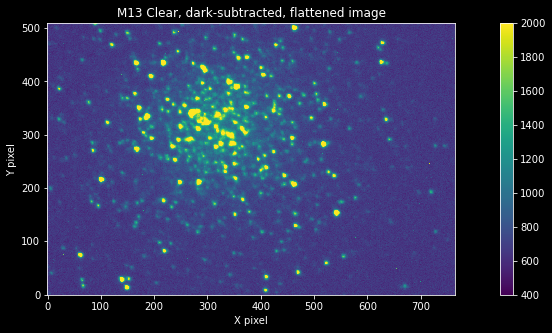

In [166]:
pl.figure(figsize=(16,5))
im = pl.imshow(M13_darksub_C_flattened, origin='lower', interpolation='none', vmax=2000, vmin=400)
pl.colorbar(im)
_=pl.title("M13 Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

In [167]:
star_centers = [[472,43], [464,501], [412,36], [518,285], [63,76], [629,474]]
width = 20
height = 20 
##[[64.6,75.8], [627.4,439.6], [629.8,474.88], [140.2,29.92], [150,15], [412,36]]
## [411,35], [471,44]] 

16:41:48.4526, +36:25:47.714
16:41:47.9901, +36:29:54.351
16:41:48.4526, +36:25:47.714
16:41:47.9901, +36:29:54.351
16:41:30.3895, +36:29:42.752
16:41:53.9756, +36:26:08.733

In [168]:
def calculate_star_flux_and_error(cutout_star, cutout_uncertainty, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = ((cutout_uncertainty[mask]**2).sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

star_centers

[[472, 43], [464, 501], [412, 36], [518, 285], [63, 76], [629, 474]]

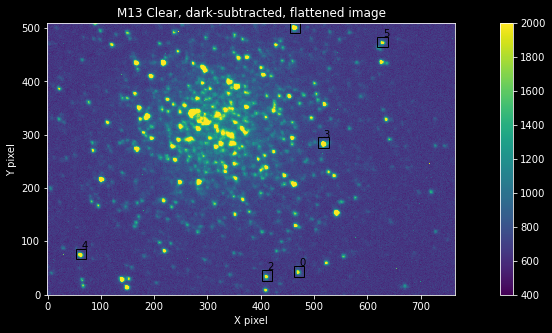

In [169]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(M13_darksub_C_flattened, 
               origin='lower', interpolation='none', vmax=2000, vmin=400)
pl.colorbar(im)
_=pl.title("M13 Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

In [170]:
for (xc, yc) in star_centers:
    slc = slice(yc-height//2,yc+height//2),slice(xc-width//2,xc+width//2)
    print(slc)

(slice(33, 53, None), slice(462, 482, None))
(slice(491, 511, None), slice(454, 474, None))
(slice(26, 46, None), slice(402, 422, None))
(slice(275, 295, None), slice(508, 528, None))
(slice(66, 86, None), slice(53, 73, None))
(slice(464, 484, None), slice(619, 639, None))


In [171]:
results = [calculate_star_flux_and_error(
    sky_subtracted_M13_clear[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    M13_darksub_C_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev)
           for (xc,yc) in star_centers]

In [174]:
M13_darksub_C_flattened_uncertainty

array([[31.16247349, 33.09875795, 31.80483539, ..., 33.15655463,
        33.32575116, 31.13886369],
       [30.21264951, 29.73814592, 30.40721759, ..., 28.54010965,
        28.69357931, 28.992595  ],
       [30.03790887, 29.4118412 , 30.90752649, ..., 30.43598685,
        30.68617606, 29.02415737],
       ...,
       [27.67688977, 27.99720557, 29.55121399, ..., 29.85723234,
        29.77874453, 30.16568207],
       [28.35787077, 29.47290767, 29.15966586, ..., 31.5065802 ,
        29.21310154, 29.66374038],
       [29.05303467, 28.81518626, 28.91990596, ..., 30.91149194,
        28.74608648, 28.77025161]])

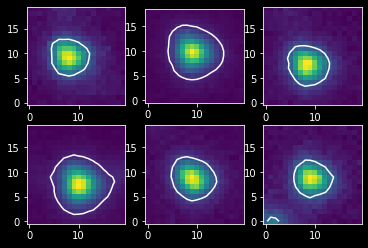

In [127]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_M13_clear[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev], colors=['w'])

In [128]:
fluxes, uncertainties = np.array(results).T

Table([np.arange(len(fluxes)), fluxes, uncertainties], names=['Star Number', 'Flux', 'Uncertainty'])

Star Number,Flux,Uncertainty
int32,float64,float64
0,54887.73220635183,2018.569093005021
1,202038.45824647456,2901.833675477675
2,70872.40259784479,2188.507085326111
3,229056.80292245708,3124.621995834513
4,90111.52391605178,2290.2877815407523
5,54272.866991865056,2061.567696973357


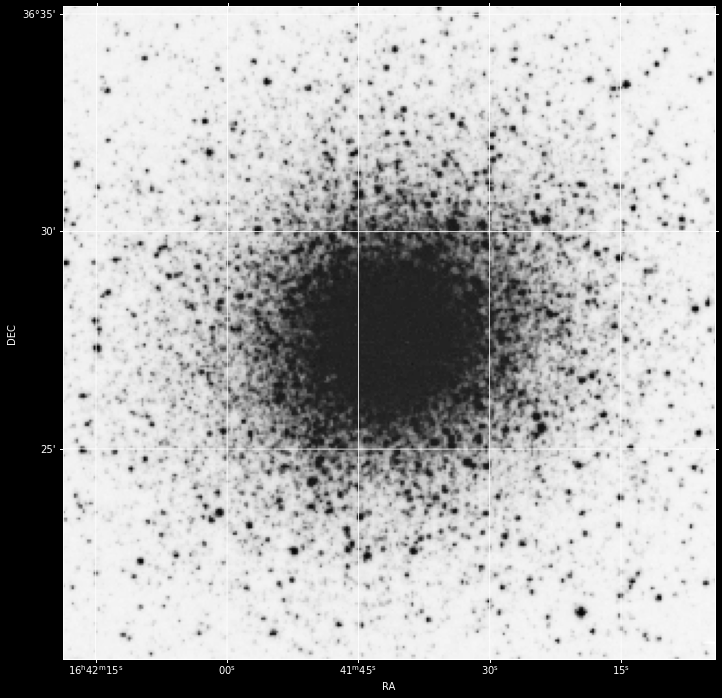

In [129]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('M13'), survey='DSS', fov_radius=15*u.arcmin)

In [130]:
star_coordinates = SkyCoord("""16:41:48.4526 +36:25:47.714
                               16:41:47.9901 +36:29:54.351
                               16:41:48.4526 +36:25:47.714
                               16:41:47.9901 +36:29:54.351
                               16:41:30.3895 +36:29:42.752
                               16:41:53.9756 +36:26:08.733""".split("\n"), frame='fk5', unit=(u.hour, u.deg))
star_coordinates

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(250.45188583, 36.42992056), (250.44995875, 36.49843083),
     (250.45188583, 36.42992056), (250.44995875, 36.49843083),
     (250.37662292, 36.49520889), (250.47489833, 36.43575917)]>

In [131]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('flux(B)', 'flux(V)', 'flux(I)')

Table([np.arange(len(fluxes)), fluxes, uncertainties, star_coordinates.ra, star_coordinates.dec],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec'])

Star Number,Flux,Uncertainty,RA,Dec
,,,deg,deg
int32,float64,float64,float64,float64
0,54887.73220635183,2018.569093005021,250.45188583333328,36.429920555555555
1,202038.45824647456,2901.833675477675,250.44995874999995,36.49843083333334
2,70872.40259784479,2188.507085326111,250.45188583333328,36.429920555555555
3,229056.80292245708,3124.621995834513,250.44995874999995,36.49843083333334
4,90111.52391605178,2290.2877815407523,250.37662291666663,36.49520888888889
5,54272.866991865056,2061.567696973357,250.47489833333333,36.435759166666664


In [132]:
simbad_rslt = Simbad.query_region(star_coordinates[0], radius=2*u.arcsec)
simbad_rslt

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,int32
NGC 6205 890,16 41 48.46,+36 25 47.4,6,6,70.000,60.000,75,C,I,2003yCat.2246....0C,--,--,--,1


In [133]:
viz_result = Vizier.query_region(star_coordinates[1], radius=2*u.arcsec, catalog='J/MNRAS/485/3042/table4')
viz_result

TableList with 1 tables:
	'0:J/MNRAS/485/3042/table4' with 25 column(s) and 1 row(s) 

In [134]:
viz_result[0]

Cluster,Star,Xpos,Ypos,Umag,e_Umag,o_Umag,Bmag,e_Bmag,o_Bmag,Vmag,e_Vmag,o_Vmag,Rmag,e_Rmag,o_Rmag,Imag,e_Imag,o_Imag,Chi,Sharp,Vary,Weight,RAJ2000,DEJ2000
,,arcsec,arcsec,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,,,,,"""h:m:s""","""d:m:s"""
str7,int32,float64,float64,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float64,float64,float32,str11,str11
NGC6205,83107,78.251,136.009,14.816,0.0014,27,14.117,0.0028,48,13.039,0.0021,92,12.431,0.0034,37,11.861,0.0026,56,1.818,0.033,0.572,128.0,16 41 47.99,+36 29 53.0


In [135]:
mags_star1 = viz_result[0]['Bmag','Vmag','Imag']
mags_star1

Bmag,Vmag,Imag
mag,mag,mag
float32,float32,float32
14.117,13.039,11.861


In [136]:
mags_for_stars_my = {}
for i in (1, 2, 3, 5):
    viz_result = Vizier.query_region(star_coordinates[i], radius=2*u.arcsec, catalog='J/MNRAS/485/3042/table4')
    mags_for_stars_my[i] = viz_result[0]['Bmag','Vmag','Imag']
mags_for_stars_my

{1: <Table length=1>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.117  13.039  11.861,
 2: <Table length=3>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  15.031  14.836  14.534
  15.461  15.380  15.341
  17.649  16.989  16.178,
 3: <Table length=1>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.117  13.039  11.861,
 5: <Table length=1>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.121  13.047  11.859}

In [137]:
b_mags = [mags_for_stars_my[i]['Bmag'][0] for i in (1, 2, 3, 5)]

v_mags = [mags_for_stars_my[i]['Vmag'][0] for i in (1, 2, 3, 5)]

i_mags = [mags_for_stars_my[i]['Imag'][0] for i in (1, 2, 3, 5)]

b_mags, v_mags, i_mags

([14.117, 15.031, 14.117, 14.121],
 [13.039, 14.836, 13.039, 13.047],
 [11.861, 14.534, 11.861, 11.859])

In [138]:
indices = [1, 2, 3, 5]
a = np.array(fluxes)
b = a[indices]
fluxes_my = list(b)

c = np.array(uncertainties)
d = c[indices]
uncertainties_my = list(d)

x = np.array(star_coordinates.ra)
y = x[indices]
star_coordinates_ra = list(y)

z = np.array(star_coordinates.dec)
t = z[indices]
star_coordinates_dec = list(t)

fluxes_my, uncertainties_my, star_coordinates_ra, star_coordinates_dec

([202038.45824647456,
  70872.40259784479,
  229056.80292245708,
  54272.866991865056],
 [2901.833675477675, 2188.507085326111, 3124.621995834513, 2061.567696973357],
 [250.44995874999995,
  250.45188583333328,
  250.44995874999995,
  250.47489833333333],
 [36.49843083333334,
  36.429920555555555,
  36.49843083333334,
  36.435759166666664])

In [139]:
cal_table_my = Table([np.arange(len(fluxes_my)), fluxes_my*u.electron, uncertainties_my*u.electron, star_coordinates_ra, star_coordinates_dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table_my

Star Number,Flux,Uncertainty,RA,Dec,Vmag,Bmag,Imag
,electron,electron,,,,,
int32,float64,float64,float64,float64,float32,float32,float32
0,202038.45824647456,2901.833675477675,250.44995874999995,36.49843083333334,13.039,14.117,11.861
1,70872.40259784479,2188.507085326111,250.45188583333328,36.429920555555555,14.836,15.031,14.534
2,229056.80292245708,3124.621995834513,250.44995874999995,36.49843083333334,13.039,14.117,11.861
3,54272.866991865056,2061.567696973357,250.47489833333333,36.435759166666664,13.047,14.121,11.859


In [141]:
exptime = fits.getheader('M13_darksub_C1_flattened.FIT')['EXPTIME'] * u.s
exptime

<Quantity 20. s>

In [142]:
star_0_electron_counts = cal_table['Flux'].quantity[0]
star_0_countrate = star_0_electron_counts / exptime
star_0_countrate

<Quantity 1765.80858616 electron / s>

In [143]:
-2.5*np.log10(star_0_countrate.value), -2.5*np.log10(star_0_electron_counts.value) + 2.5*np.log10(exptime.value)

star_0_instrumental_mag = -2.5*np.log10(star_0_countrate.value)
zeropoint = mag_v_0 - star_0_instrumental_mag 
star_0_instrumental_mag, zeropoint

(-8.117359060563338, 22.775359052933943)

In [144]:
zeropoint_measurements = []
for row in cal_table:
    mag_v = row['Vmag']
    if mag_v:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_v - star_instrumental_mag 
        print(f"Instrumental magnitude of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements.append(zeropoint)

Instrumental magnitude of star 0=-8.1, m_zp=22.8
Instrumental magnitude of star 1=-8.3, m_zp=22.4
Instrumental magnitude of star 2=-8.2, m_zp=22.1
Instrumental magnitude of star 4=-7.4, m_zp=22.0


In [145]:
mag_sky_inst = -2.5 * np.log10(sky_mean / exptime.value)
mag_sky_inst

-3.9647537120658787

In [146]:
mag_sky = mag_sky_inst + avg_zp
print(f"Sky magnitude is {mag_sky:0.1f} per pixel")

pixscale = 0.55*u.arcsec

sky_brightness = mag_sky + 2.5*np.log10(pixscale**2 / u.arcsec**2)
print(f"The sky surface brightness is {sky_brightness:0.1f} magnitudes per square arcsecond")mag_sky = mag_sky_inst + avg_zp
print(f"Sky magnitude is {mag_sky:0.1f} per pixel")

pixscale = 0.55*u.arcsec

sky_brightness = mag_sky + 2.5*np.log10(pixscale**2 / u.arcsec**2)
print(f"The sky surface brightness is {sky_brightness:0.1f} magnitudes per square arcsecond")

Sky magnitude is 17.9 per pixel
The sky surface brightness is 16.6 magnitudes per square arcsecond


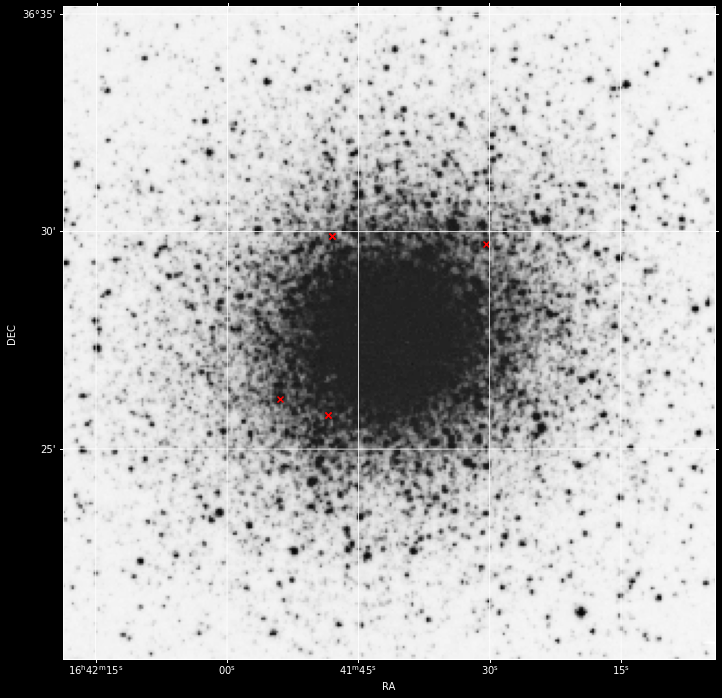

In [147]:
pl.figure(figsize=(12,12))
ax, hdu = plot_finder_image(SkyCoord.from_name('M13'), survey='DSS', fov_radius=15*u.arcmin)
ax.scatter(star_coordinates.ra.deg, star_coordinates.dec.deg, transform=ax.get_transform('fk5'), marker='x', color='r')

In [ ]:
## importing in Flats
clear_flat = glob.glob("Twighlight Flats\\flat_15s_Clear*FIT")
I_flat = glob.glob("Twighlight Flats\\flat_10s_I*FIT")
B_flat = glob.glob("Twighlight Flats\\flat_15s_B*FIT")
V_flat = glob.glob("Twighlight Flats\\flat_15s_V*FIT")

In [ ]:
# Making a datacube/timestresm/timesearies(all same things) 
# of the flats, finding the mean of the flat, bias subtracting the flat by subtracting 
# the mean flat by the mean bias, 
# we use the mean for noise reduction. Flat fields vary alot as a trend as
# sun gets lower, dflat fields get dimer. Medial of 3 images you'll get back middle one
# so noise isn't reduced 

#Clear, B , V , I
flat = [clear_flat, B_flat, V_flat, I_flat]
flat_timestream = []
mean_flat = []
bias_subtracted_flat = []
normed_flat = []

## flat processing
for i in range(4):
    flat_timestream.append([fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in flat[i]])
    mean_flat.append(np.mean(flat_timestream[i], axis=0))
    bias_subtracted_flat.append(mean_flat[i] - mean_bias)
    normed_flat.append(bias_subtracted_flat[i]/bias_subtracted_flat[i].mean())
    
del flat_timestream

# uncertainties 
flat_poisson_uncertainty = []
flat_singleframe_uncertainty = []
flat_total_uncertainty = []
normalized_mean_flat = []

for i in range(4):
    flat_poisson_uncertainty.append((bias_subtracted_flat[i])**0.5)
    flat_singleframe_uncertainty.append((flat_poisson_uncertainty[i]**2 + readnoise**2)**0.5)
    flat_total_uncertainty.append(((flat_singleframe_uncertainty[i]/np.sqrt(len(flat[i])))**2 + mean_bias_noise**2)**0.5)
    mean_of_flat = np.mean(bias_subtracted_flat[i])
    normalized_mean_flat.append(bias_subtracted_flat[i] / mean_of_flat)

# normalized flats
normalized_flat_uncertainty = []
for i in range(4):
    normalized_flat_uncertainty.append(flat_total_uncertainty[i] / mean_of_flat)    